[*********************100%***********************]  1 of 1 completed

Epoch 1/10



c:\Users\CLIENTE\anaconda3\envs\orlando\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0649 - mean_absolute_error: 0.1852
Epoch 1: loss improved from inf to 0.03132, saving model to melhor_modelo_multivariado.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0637 - mean_absolute_error: 0.1830 - learning_rate: 0.0010
Epoch 2/10
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0120 - mean_absolute_error: 0.0834
Epoch 2: loss improved from 0.03132 to 0.01231, saving model to melhor_modelo_multivariado.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0120 - mean_absolute_error: 0.0834 - learning_rate: 0.0010
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0121 - mean_absolute_error: 0.0840
Epoch 3: loss improved from 0.01231 to 0.01145, saving model to melhor_modelo_multivariado.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0121 - mean_absolute_error: 0.0839 - learning_rate: 0.0010
Epoch 4/10
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0100 - mean_absolute_error: 0.0757
Epoch 4: loss

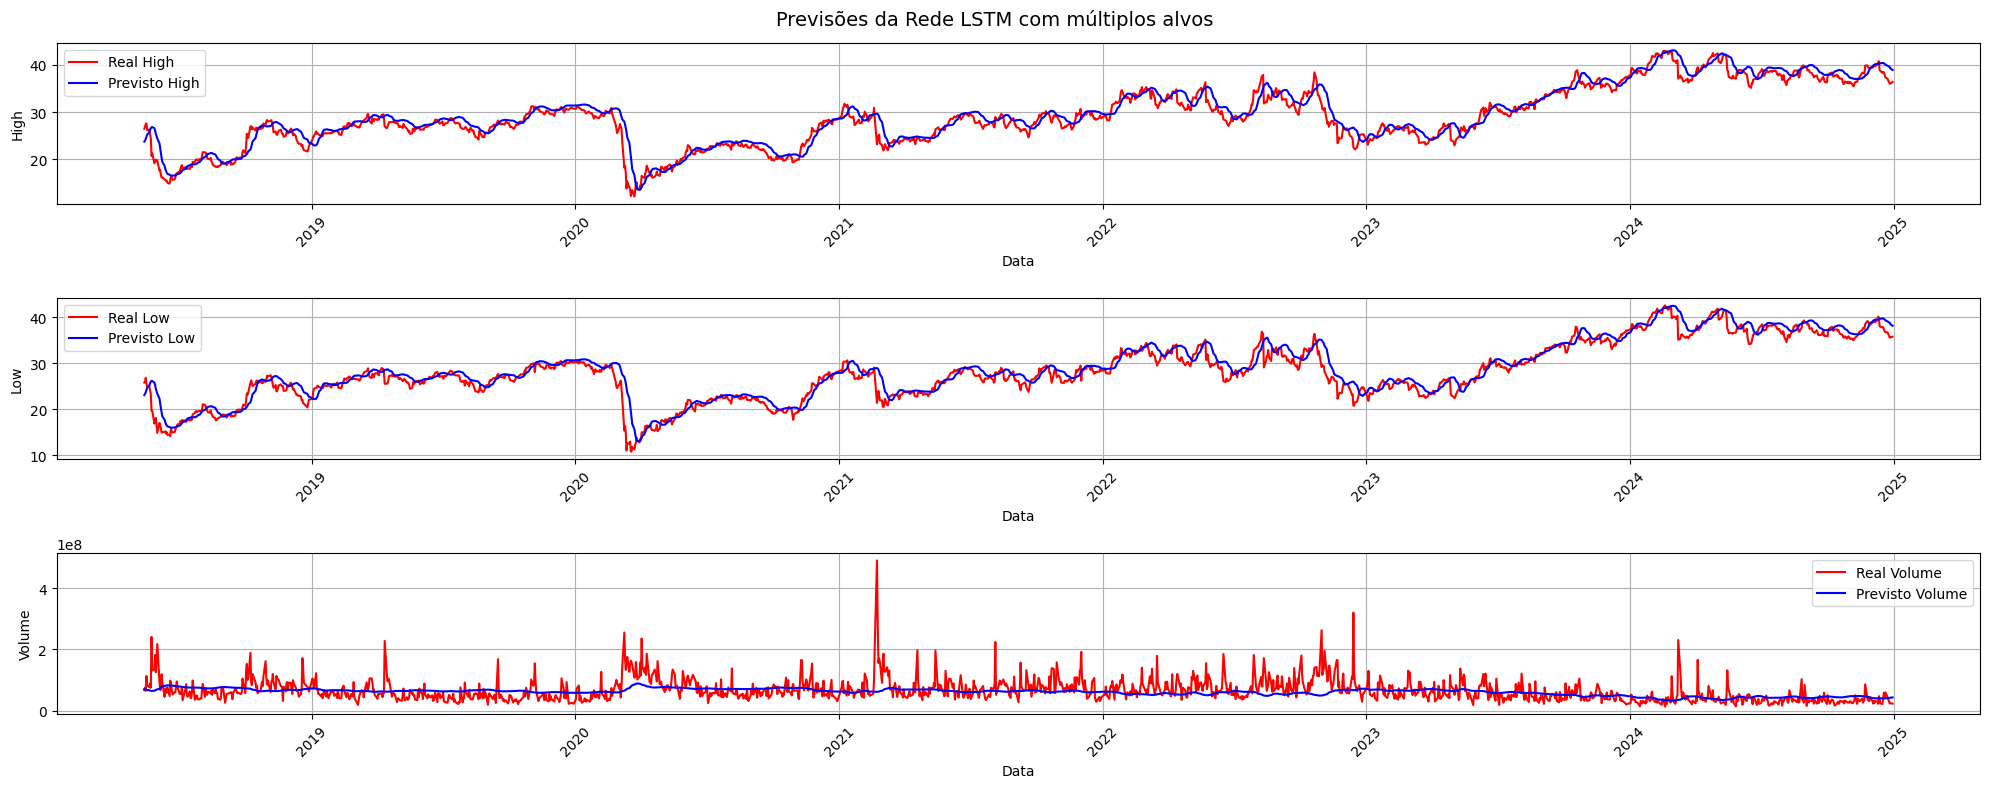

MAE (média entre os 3 alvos): 7637824.27


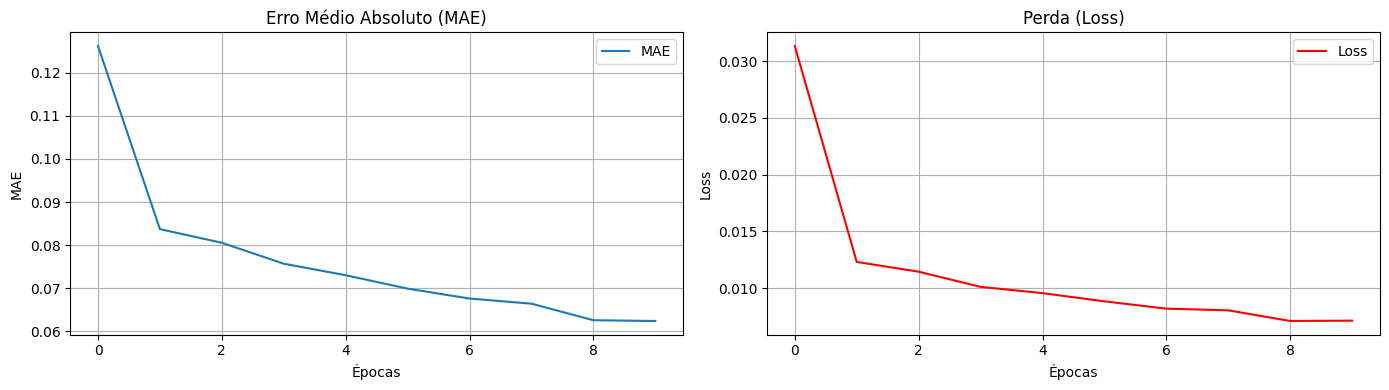

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# 1 - Coleta dados históricos da PETR4
base = yf.download('PETR4.SA', start='2018-01-02', end='2024-12-31', auto_adjust=False)

# 2 - Preparar entradas (X) e saída (y)
entradas_X = base[['Open', 'Close']].values
saida_y = base[['High', 'Low', 'Volume']].values

# 3 - Normalização
normalizador_X = MinMaxScaler()
normalizador_y = MinMaxScaler()
X_normalizado = normalizador_X.fit_transform(entradas_X)
y_normalizado = normalizador_y.fit_transform(saida_y)

# 4 - Criar janelas com lookback de 90 dias
X = []
y = []
lookback = 90
for i in range(lookback, len(X_normalizado)):
    X.append(X_normalizado[i-lookback:i])
    y.append(y_normalizado[i])

X = np.array(X)
y = np.array(y)

# 5 - Modelo
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=3, activation='linear'))  # 3 saídas agora: High, Low, Volume

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# 6 - Treinamento
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='melhor_modelo_multivariado.keras', monitor='loss', save_best_only=True, verbose=1)

historico = regressor.fit(X, y, epochs=10, batch_size=32, callbacks=[es, rlr, mcp])

# 7 - Previsões
previsoes = regressor.predict(X)
previsoes = normalizador_y.inverse_transform(previsoes)
y_real = normalizador_y.inverse_transform(y)
datas = base.index[lookback:]

# 8 - Gráfico do ajuste (real vs predito) para cada saída
plt.figure(figsize=(20, 8))
labels = ['High', 'Low', 'Volume']
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(datas, y_real[:, i], label=f'Real {labels[i]}', color='red')
    plt.plot(datas, previsoes[:, i], label=f'Previsto {labels[i]}', color='blue')
    plt.ylabel(labels[i])
    plt.xlabel('Data')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
plt.suptitle("Previsões da Rede LSTM com múltiplos alvos", fontsize=14)
plt.tight_layout()
plt.show()

# 9 - Métrica
mae = mean_absolute_error(y_real, previsoes)
print(f"MAE (média entre os 3 alvos): {mae:.2f}")

# 10 - Gráfico de perda e acurácia
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(historico.history['mean_absolute_error'], label='MAE')
axs[0].set_title('Erro Médio Absoluto (MAE)')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('MAE')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(historico.history['loss'], label='Loss', color='red')
axs[1].set_title('Perda (Loss)')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [4]:
import plotly.graph_objects as go

# Simulando dados (substitua pelos seus)
import pandas as pd
import numpy as np

# Gráfico interativo com Plotly
fig = go.Figure()

# Linhas reais
fig.add_trace(go.Scatter(x=datas, y=y_real[:, 0], mode='lines', name='High Real', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=datas, y=y_real[:, 1], mode='lines', name='Low Real', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=datas, y=y_real[:, 2], mode='lines', name='Volume Real', line=dict(color='purple', dash='dash')))

# Linhas previstas
fig.add_trace(go.Scatter(x=datas, y=previsoes[:, 0], mode='lines+markers', name='High Previsto', line=dict(color='orange')))

fig.add_trace(go.Scatter(x=datas, y=previsoes[:, 1], mode='lines+markers', name='Low Previsto', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=datas, y=previsoes[:, 2], mode='lines+markers', name='Volume Previsto', line=dict(color='brown')))

fig.update_layout(
    title='revisão de High, Low e Volume - PETR4',
    xaxis_title='Data',
    yaxis_title='Valores',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99, borderwidth=1),
    hovermode='x unified',
    autosize=True,
    width=1100,
    height=500
)

fig.show()
